In [1]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np
import ta

In [3]:
df = pd.read_csv("data/2330_TW.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-03,73.997704,74.358668,73.636739,74.358668,38599000,NaN,NaN,NaN
2014-01-06,73.997704,74.358668,73.636739,73.636739,23706000,NaN,NaN,NaN
2014-01-07,73.636726,74.358655,73.636726,73.997691,15836000,NaN,NaN,NaN
2014-01-08,75.080612,75.441577,73.997719,74.358683,30218000,NaN,NaN,NaN
2014-01-09,72.914787,74.358644,72.553823,73.997680,63998000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-25,564.011108,567.894145,563.040349,564.981868,9548143,58.299930,71.936110,67.926818
2023-12-26,568.864929,568.864929,564.981892,565.952651,16094308,62.416420,91.982151,79.954442
2023-12-27,574.689453,574.689453,568.864898,569.835657,33401336,66.668544,100.000000,87.972754


In [4]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
X_train.shape[2]

(2439, 4)
torch.Size([1935, 5, 4])


4

In [5]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # 建立一個位置編碼矩陣
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數位置
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x 的形狀為 (seq_length, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return x

In [6]:
import torch
import torch.nn as nn

class TransformerTimeSeriesAutoregressive(nn.Module):
    def __init__(self, feature_size, num_layers=2, nhead=4, hidden_dim=128, gru_hidden_dim=128, dropout=0.3):
        super(TransformerTimeSeriesAutoregressive, self).__init__()
        self.model_type = 'Autoregressive Transformer with GRU Decoder and Teacher Forcing'

        self.input_linear = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Linear projection for h_0
        self.h0_projection = nn.Linear(hidden_dim, gru_hidden_dim)

        self.gru_decoder = nn.GRU(input_size=hidden_dim, hidden_size=gru_hidden_dim, num_layers=1, batch_first=False)
        self.output_linear = nn.Linear(gru_hidden_dim, feature_size)

        self.residual_projection = nn.Linear(feature_size, hidden_dim) if feature_size != hidden_dim else None
        self.hidden_dim = hidden_dim
        self.gru_hidden_dim = gru_hidden_dim

    def forward(self, src, target=None, teacher_forcing_ratio=0.5):
        batch_size, seq_length, feature_size = src.size()
        pred_length = target.size(1) if target is not None else 5

        if self.residual_projection:
            residual_src = self.residual_projection(src)
        else:
            residual_src = src

        residual_src = residual_src.permute(1, 0, 2)
        src = src.permute(1, 0, 2)
        src = self.input_linear(src)
        src = self.pos_encoder(src)

        transformer_output = self.transformer_encoder(src)
        transformer_output = transformer_output + residual_src

        # Use the last timestep's output to initialize h_0
        last_step_output = transformer_output[-1]  # (batch_size, hidden_dim)
        h_0 = self.h0_projection(last_step_output).unsqueeze(0)  # (1, batch_size, gru_hidden_dim)

        # Start autoregressive decoding
        decoder_input = transformer_output[-1, :, :].unsqueeze(0)  # (1, batch_size, hidden_dim)
        outputs = []

        for t in range(pred_length):
            gru_output, h_0 = self.gru_decoder(decoder_input, h_0)
            gru_output = gru_output + decoder_input
            output = self.output_linear(gru_output.squeeze(0))
            outputs.append(output.unsqueeze(1))

            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = self.input_linear(target[:, t, :]).unsqueeze(0)
            else:
                decoder_input = self.input_linear(output).unsqueeze(0)

        outputs = torch.cat(outputs, dim=1)
        return outputs


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 1e-4

feature_size = 4  # 輸入特徵數
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeriesAutoregressive(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


c:\Users\N98141062\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "output/model/2330tw/trans_gru_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        # print(x_batch.shape)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.5).squeeze(-1)
        # print(outputs.shape)
        # print(y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.0).squeeze(-1)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path)  
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.0381, Val Loss: 0.0573
Epoch [2/100], Train Loss: 0.0992, Val Loss: 0.0255
Epoch [3/100], Train Loss: 0.0318, Val Loss: 0.0105
Epoch [4/100], Train Loss: 0.0082, Val Loss: 0.0030
Epoch [5/100], Train Loss: 0.0059, Val Loss: 0.0037
Epoch [6/100], Train Loss: 0.0051, Val Loss: 0.0026
Epoch [7/100], Train Loss: 0.0045, Val Loss: 0.0026
Epoch [8/100], Train Loss: 0.0039, Val Loss: 0.0015
Epoch [9/100], Train Loss: 0.0035, Val Loss: 0.0013
Epoch [10/100], Train Loss: 0.0033, Val Loss: 0.0009
Epoch [11/100], Train Loss: 0.0034, Val Loss: 0.0011
Epoch [12/100], Train Loss: 0.0037, Val Loss: 0.0011
Epoch [13/100], Train Loss: 0.0035, Val Loss: 0.0012
Epoch [14/100], Train Loss: 0.0057, Val Loss: 0.0028
Epoch [15/100], Train Loss: 0.0042, Val Loss: 0.0075
Epoch [16/100], Train Loss: 0.0044, Val Loss: 0.0027
Epoch [17/100], Train Loss: 0.0044, Val Loss: 0.0047
Epoch [18/100], Train Loss: 0.0058, Val Loss: 0.0181
Epoch [19/100], Train Loss: 0.0054, Val Loss: 0.0161
Ep

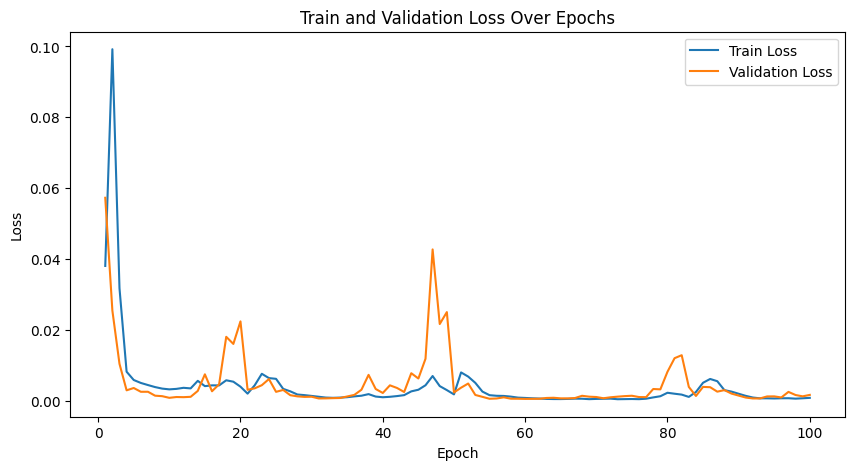

In [9]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

C:\Users\N98141062\AppData\Local\Temp\ipykernel_16292\393115431.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/2330tw/trans_gru_5.pth')

MAE:  9.9854
RMSE: 12.1475
MAPE: 1.9508%
R²:   0.7878


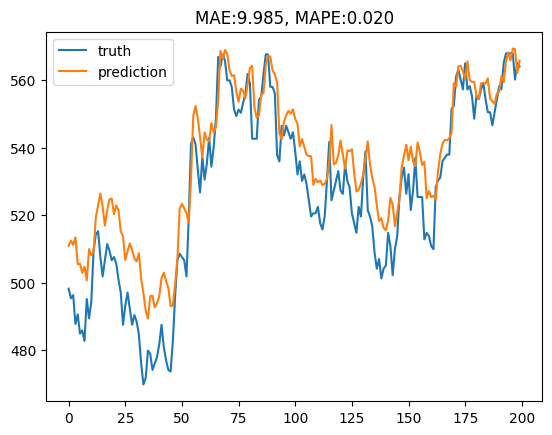

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
close_price_true = []
close_price_pred = []
model = torch.load('output/model/2330tw/trans_gru_5.pth')
model.to(device)

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0).squeeze(-1)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['truth', 'prediction'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [11]:
btdf = pd.DataFrame({'close':df['Close'][-204:-4], 'rsi':df['rsi'][-204:-4],'predicted_close':close_price_pred})

In [12]:
btdf =btdf.dropna().reset_index(drop=True)

In [13]:
btdf

,close,rsi,predicted_close
0,498.186188,54.665447,510.856193
1,495.333923,52.878740,512.436033
2,496.284729,53.425225,511.155738
3,487.728088,48.027092,513.405043
4,490.580261,49.846199,505.426612
...,...,...,...
195,567.894043,65.586338,565.835086
196,567.894043,65.586338,569.341004
197,560.128052,55.190730,569.121427
198,564.981812,59.510359,562.054110


買入價格: 495.33392333984375
賣出價格: 567.57080078125
cash: 1145774.0186767578
額外要扣掉: 4776.389004629516
扣掉後的: 1140997.6296721282
-------------------------------------
買入價格: 557.96728515625
賣出價格: 554.318603515625
cash: 1133539.7243986907
額外要扣掉: 4941.525316148954
扣掉後的: 1128598.1990825417
-------------------------------------
買入價格: 557.2158203125
賣出價格: 554.318603515625
cash: 1122731.3350688699
額外要扣掉: 4892.241588769067
扣掉後的: 1117839.0934801009
-------------------------------------
買入價格: 550.4557495117188
賣出價格: 567.89404296875
cash: 1153238.8291978743
額外要扣掉: 4966.144283612926
扣掉後的: 1148272.6849142613
-------------------------------------
買入價格: 567.89404296875
賣出價格: 564.0111083984375
最終價格: 1140425.2741476598


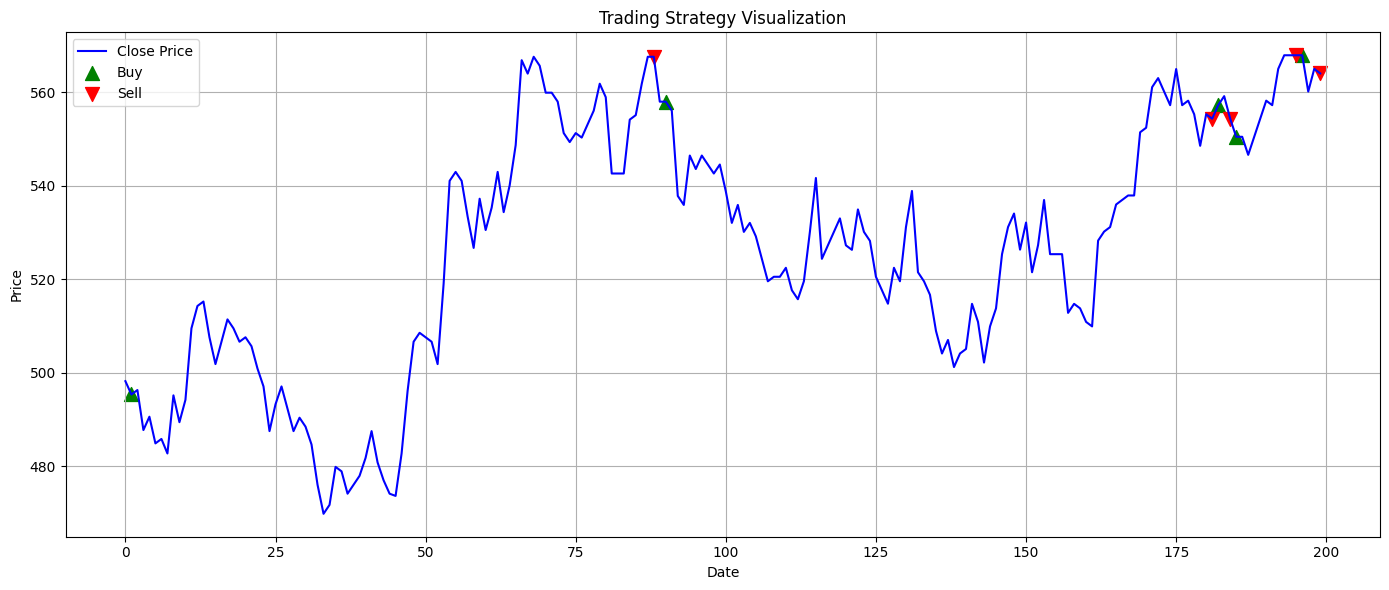

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 495.33392333984375
賣出價格: 564.0111083984375
最終價格: 1138590.5594482422


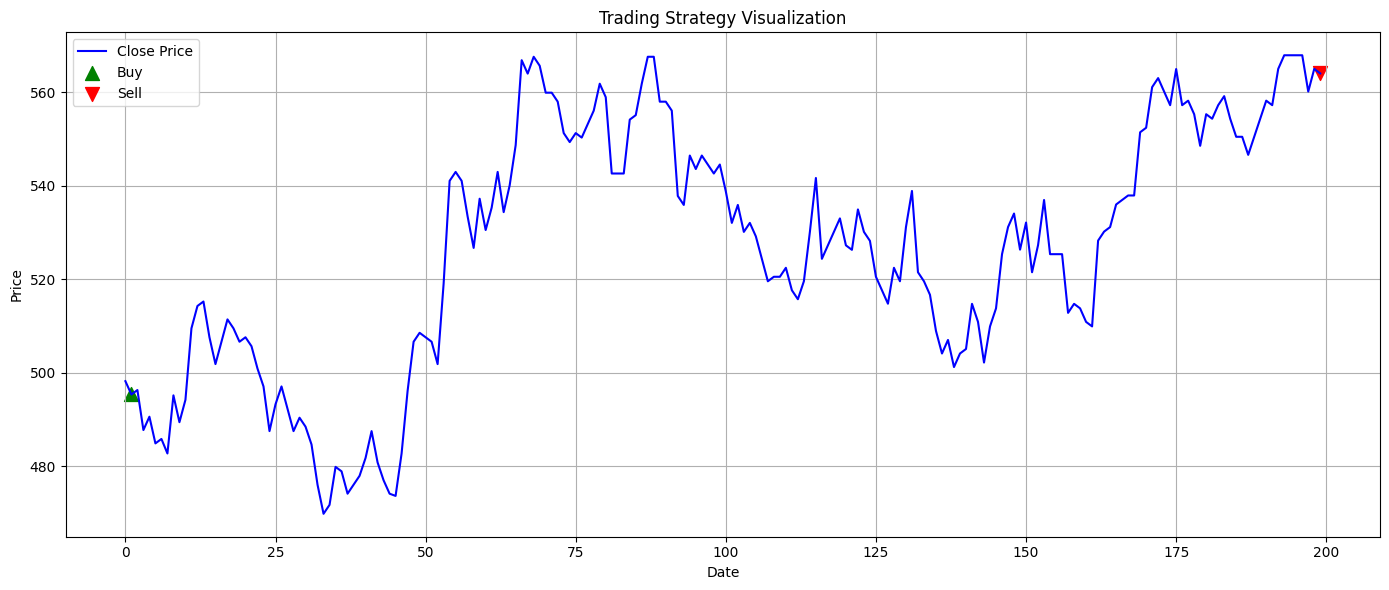

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 75.704 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

(200, 5)
(200, 5)
MAE:  11.9741
RMSE: 14.5309
MAPE: 2.3163%
R²:   0.6975


In [17]:
df = pd.read_csv("data/2330_TW.csv")
df = df[23:]

In [18]:
df['Date'][:-1]

23      2014-01-03
24      2014-01-06
25      2014-01-07
26      2014-01-08
27      2014-01-09
           ...    
2456    2023-12-22
2457    2023-12-25
2458    2023-12-26
2459    2023-12-27
2460    2023-12-28
Name: Date, Length: 2438, dtype: object

In [19]:
df['Date'][2257]

'2023-03-06'

In [20]:
Date=[]
for i in range(len(test_set)):
    Date.append(df['Date'][2257+i])
len(Date)

200

In [21]:
import csv

with open('output/2330tw_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(Date)):
    rows[i].append(Date[i])

# 寫回檔案
with open('output/2330tw_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

In [22]:
import csv

with open('output/2330tw_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i][0].item())

# 寫回檔案
with open('output/2330tw_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)